In [1]:
import torch
from torch import nn # torch.nn contains all of the building blocks required for a neural network in pytorch
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)

2.0.1+cu118


## 1. Data (preparing and loading)

In [2]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = (weight * X) + bias

In [3]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
print(X.shape, y.shape)

torch.Size([50, 1]) torch.Size([50, 1])


### Splitting the data into training and test data

In [5]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [6]:
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

### Create a plotting function

In [7]:
def plot_data(x_train=X_train,
              x_test=X_test,
              y_train=y_train,
              y_test=y_test,
              predictions=None):
    plt.figure(figsize=(10, 7), dpi=200)
    plt.scatter(x_train, y_train, c="b", s=14, label="Training Data")
    plt.scatter(x_test, y_test, c="g", s=14, label="Testing Data")
    if predictions is not None:
        plt.scatter(x_test, predictions, s=14, c="r", label="Predictions")
    plt.legend(prop={"size":14});


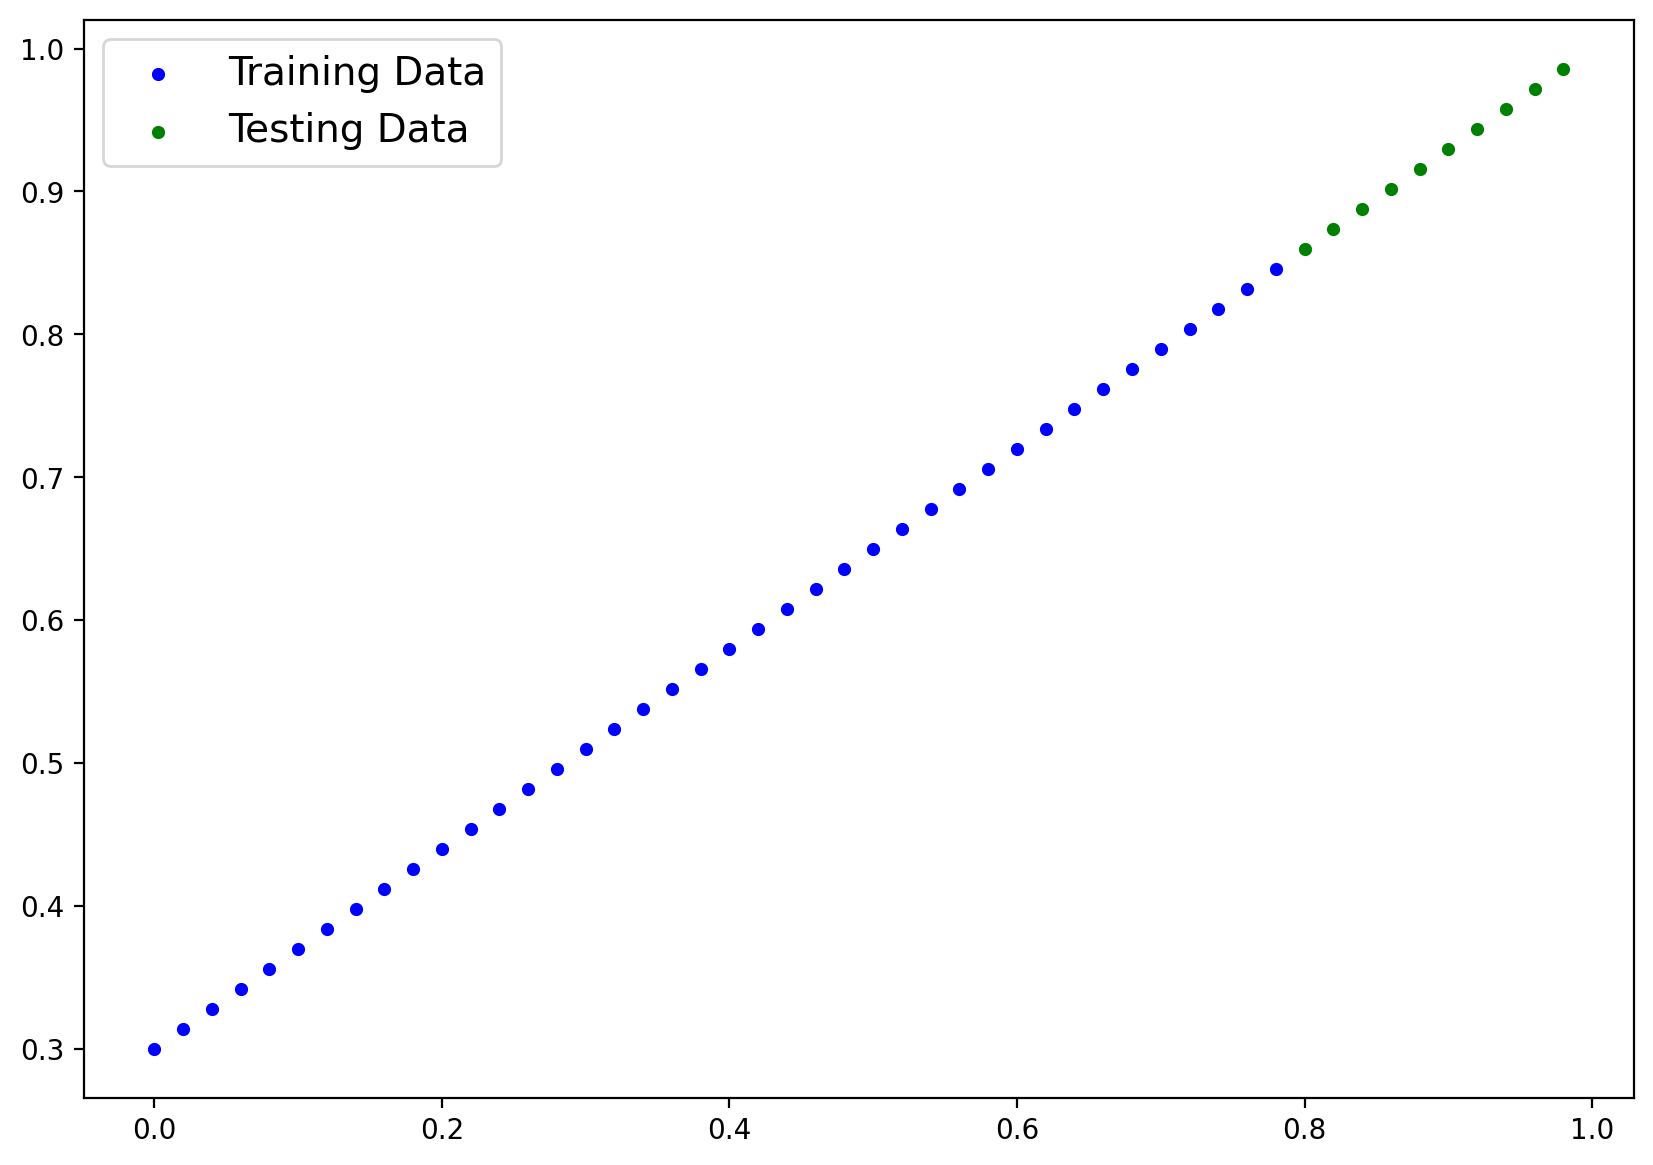

In [8]:
plot_data();

## Create our linear regression model

In [9]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__() # Calls the __init__() method of the nn.modules (super class)
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                                requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),
                                             requires_grad=True)
        
    def forward(self, x:torch.tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### Pytorch model building essentials
* `torch.nn` - contains all of the building blocks for computational graphs (a neural network can be considered as a computational graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - The base class for all neural network modules, if u subclass it, you should overwrite `forward()`
* `torch.optim` - this is where the optimizers in PyTorch livem they will help with gradient descent
* `def dorward()` - All `nn.Module` subclasses require you to overwrite `forward()`, this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

In [10]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegression()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [12]:
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds


tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

 Another alternative for `toch.inference_mode()` is `torch.no_grad()` but `torch.inference_mode()` is faster and newer implementation in pytorch

In [13]:
with torch.no_grad():
    y_preds_1 = model_0(X_test)
y_preds_1

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
# If we make predictions without using `torch.inference_mode()`, torch also keeps track of the gradients which makes the inference slower
y_preds_grad = model_0(X_test)
y_preds_grad

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

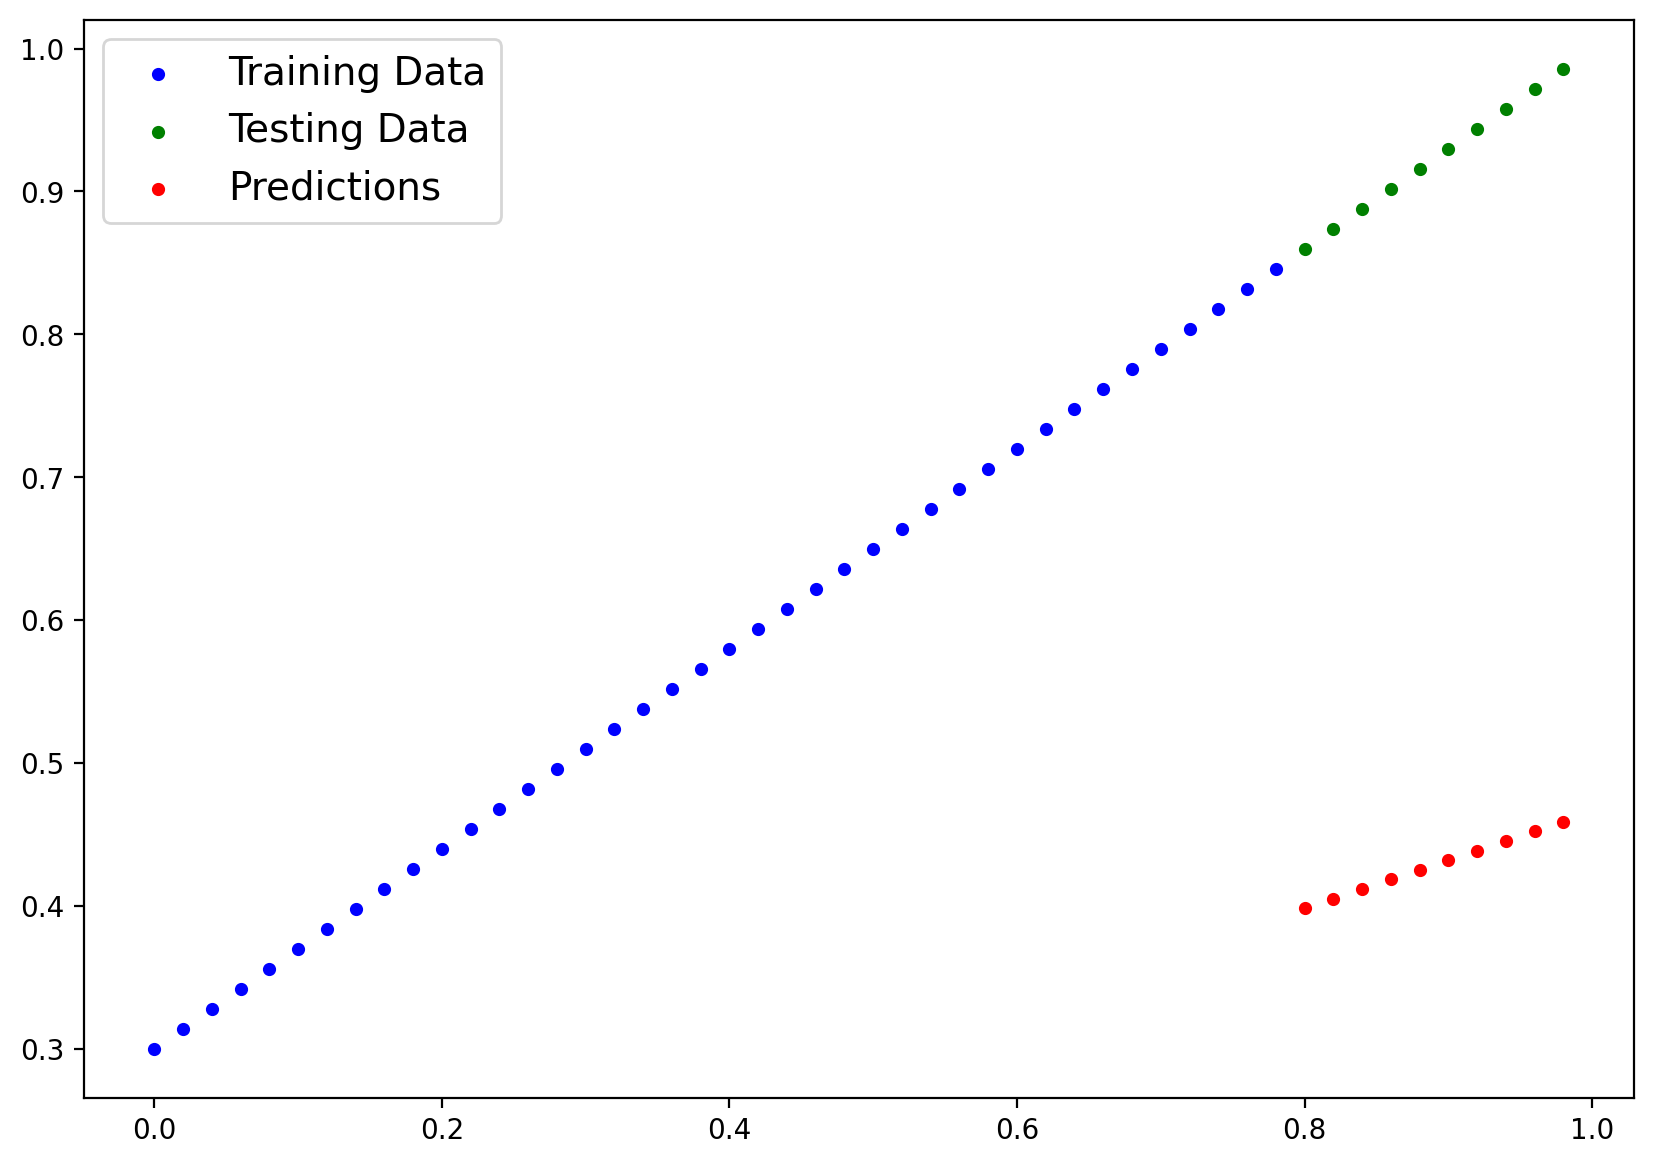

In [15]:
plot_data(predictions=y_preds)

## 3. Train a model
The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weights & biases in our case) to imporove the loss function.
    * Inside the optimizer you'll often have to set two parameters:
        * `params` - the model parameters you'd like to optimize, for example `params=model_0.parameters()`
        * `lr` (learning rate) - the learning rate is a hyperparameter that defines how big/small the optimizer changes the     parameters with each step

And specifically for PyTorch, we need:
* A training loop 
* A testing loop

In [16]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [18]:
# Setup the loss function
loss_fn = nn.L1Loss()

# Setup the SGD optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop) in PyTorch
A couple of things we need in a training loop:

0. Loop through the data

1. Forward pass (this invloves data moving through our model's `forward()` functions) to amek predictions on data - also called forward propagation

2. Calculate the loss (compare forward pass predictions to ground truth labels)

3. Optimizer zero grad

4. Loss backward - move backwards through the network to calculate the gradients of each of the parametters of our model with respect to the loss (**backpropagation**)

5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [19]:
torch.manual_seed(42)
epochs = 200

# Track values
epoch_count = []
loss_values = []
test_loss_values = []
### Training
# 0. Loop through the data
for epoch in range(epochs+1):
    # Set the model to training mode (this is the default state of a model)
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients


    # 1. Forward pass on the training data using forward() method
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    # print(f"Loss: {loss}")

    # 3. Optimizer zero_grad (Zero the gradients of the optimizer (they accumulate by default))
    optimizer.zero_grad()

    # 4. Backpropagation on the loss (compute gradient of every parameter where the requires_grad=True)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    
    
    model_0.eval() # turns off different settings in the model which are not needed like batchnorm, dropout
    with torch.inference_mode(): # turns of gradient tracking
        # 1. Forward Pass
        y_pred = model_0(X_test)
        # 2. Compute loss
        test_loss = loss_fn(y_pred, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test_loss: {test_loss}")
        print(model_0.state_dict())
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)



Epoch: 0 | Loss: 0.31288138031959534 | Test_loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test_loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test_loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test_loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test_loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test_loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test_loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [20]:
loss_values

[tensor(0.3129, grad_fn=<MeanBackward0>),
 tensor(0.3014, grad_fn=<MeanBackward0>),
 tensor(0.2898, grad_fn=<MeanBackward0>),
 tensor(0.2783, grad_fn=<MeanBackward0>),
 tensor(0.2668, grad_fn=<MeanBackward0>),
 tensor(0.2553, grad_fn=<MeanBackward0>),
 tensor(0.2438, grad_fn=<MeanBackward0>),
 tensor(0.2322, grad_fn=<MeanBackward0>),
 tensor(0.2207, grad_fn=<MeanBackward0>),
 tensor(0.2092, grad_fn=<MeanBackward0>),
 tensor(0.1977, grad_fn=<MeanBackward0>),
 tensor(0.1862, grad_fn=<MeanBackward0>),
 tensor(0.1746, grad_fn=<MeanBackward0>),
 tensor(0.1631, grad_fn=<MeanBackward0>),
 tensor(0.1516, grad_fn=<MeanBackward0>),
 tensor(0.1401, grad_fn=<MeanBackward0>),
 tensor(0.1285, grad_fn=<MeanBackward0>),
 tensor(0.1170, grad_fn=<MeanBackward0>),
 tensor(0.1061, grad_fn=<MeanBackward0>),
 tensor(0.0968, grad_fn=<MeanBackward0>),
 tensor(0.0891, grad_fn=<MeanBackward0>),
 tensor(0.0823, grad_fn=<MeanBackward0>),
 tensor(0.0764, grad_fn=<MeanBackward0>),
 tensor(0.0716, grad_fn=<MeanBackw

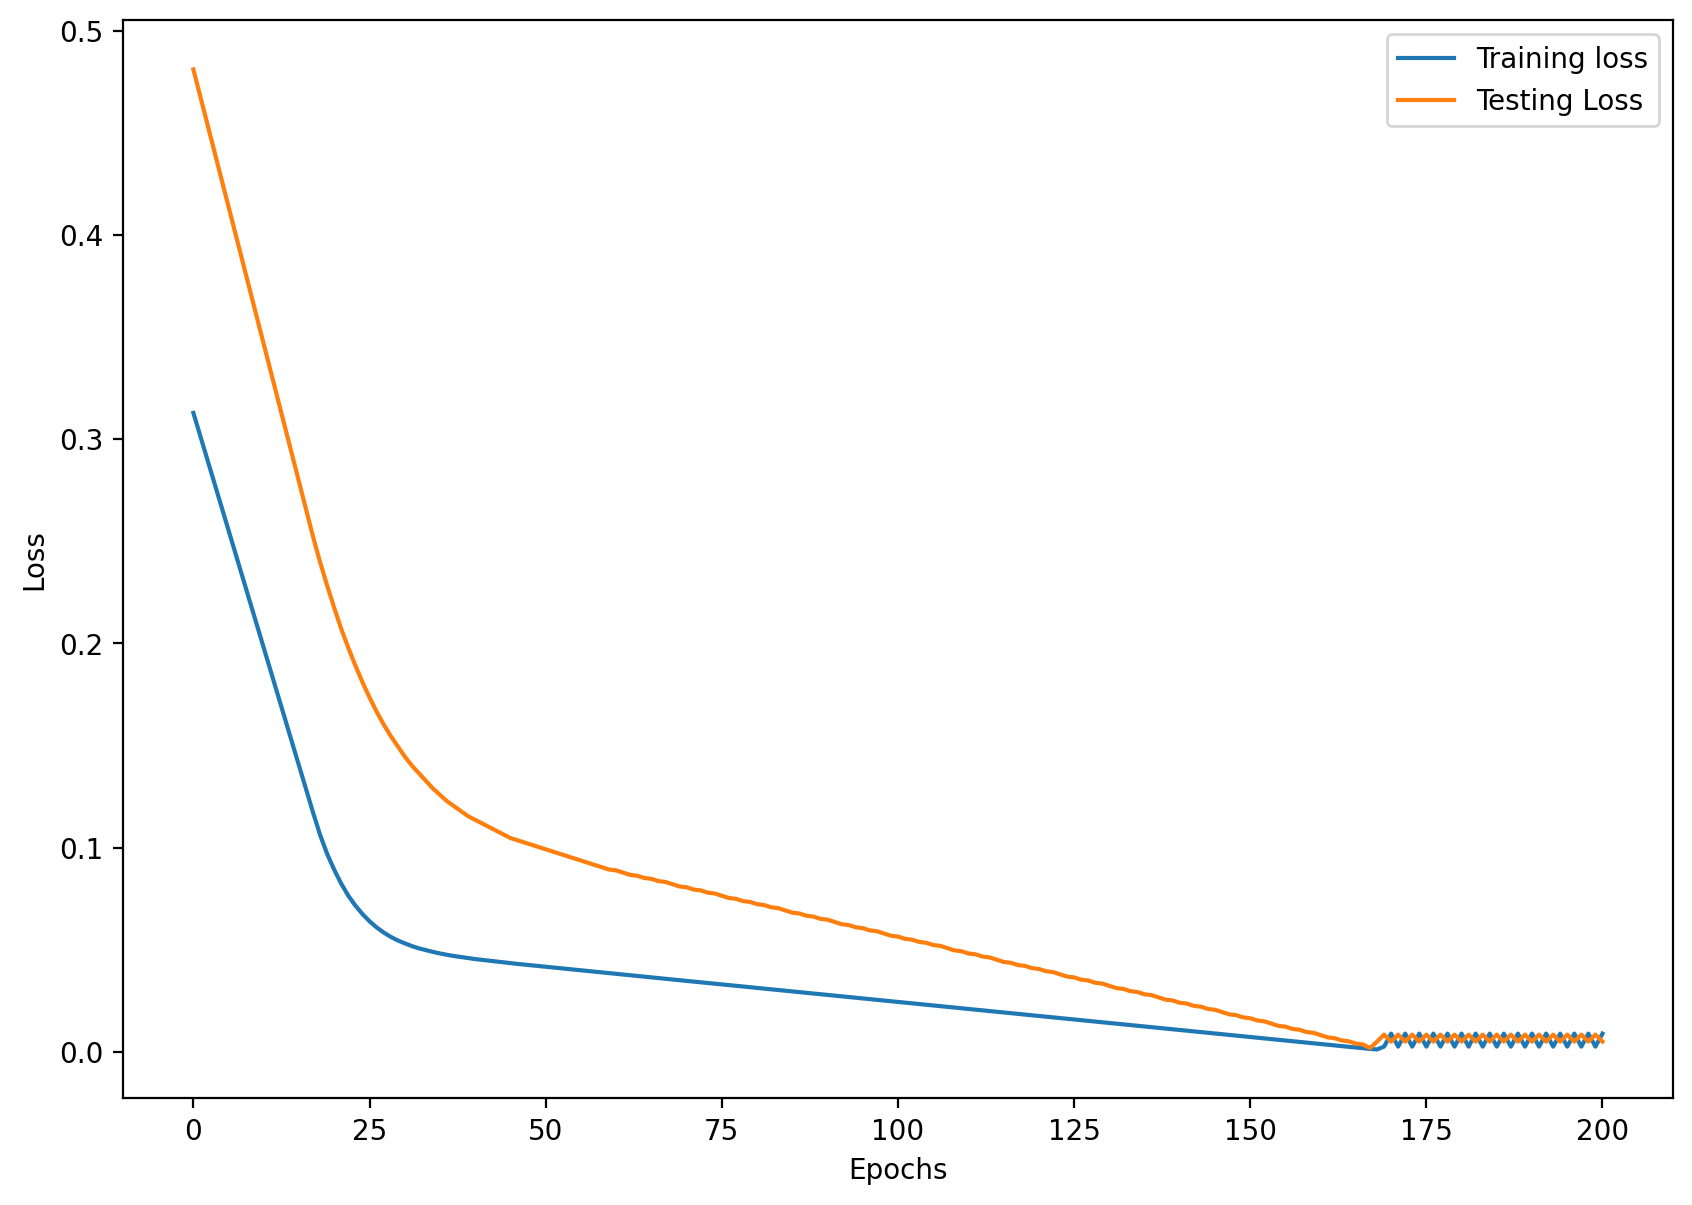

In [21]:
plt.figure(figsize=(10, 7), dpi=200)
plt.plot(epoch_count, np.array(torch.tensor(loss_values)), label="Training loss")
plt.plot(epoch_count, test_loss_values, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [23]:
weight, bias

(0.7, 0.3)

In [24]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

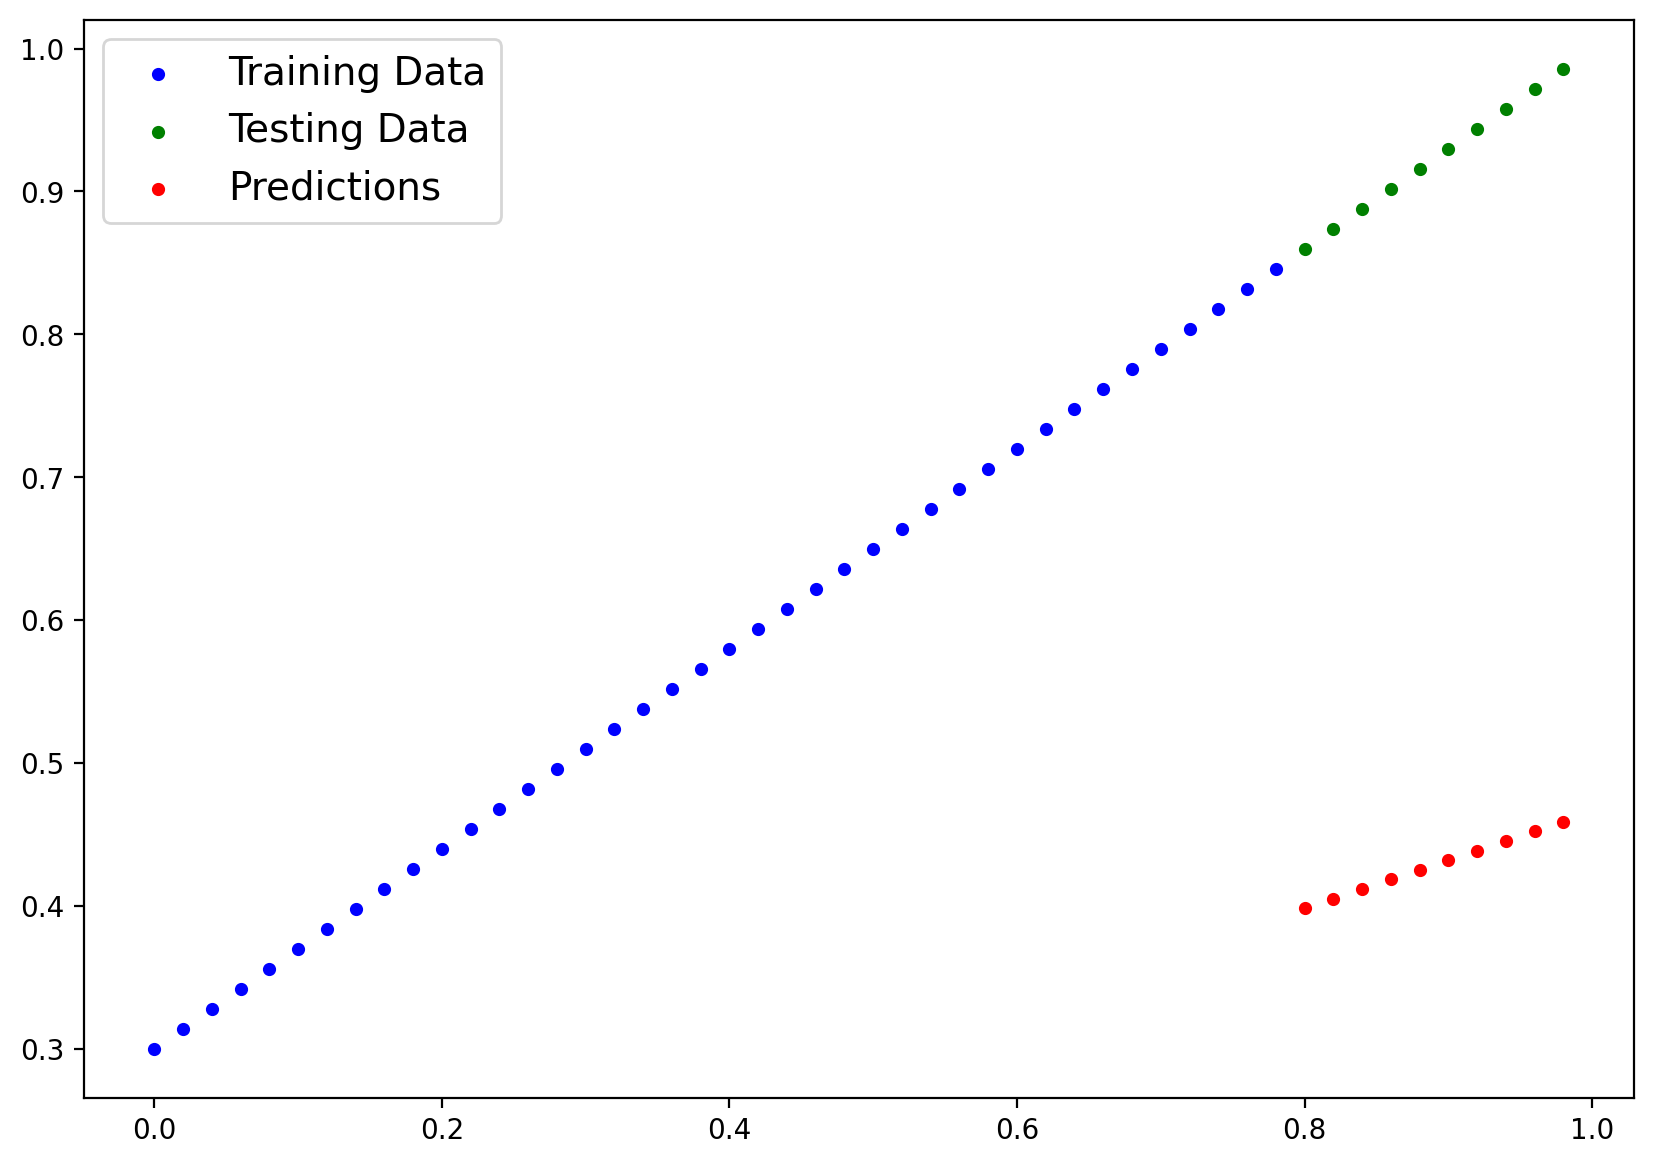

In [25]:
plot_data(predictions=y_preds)

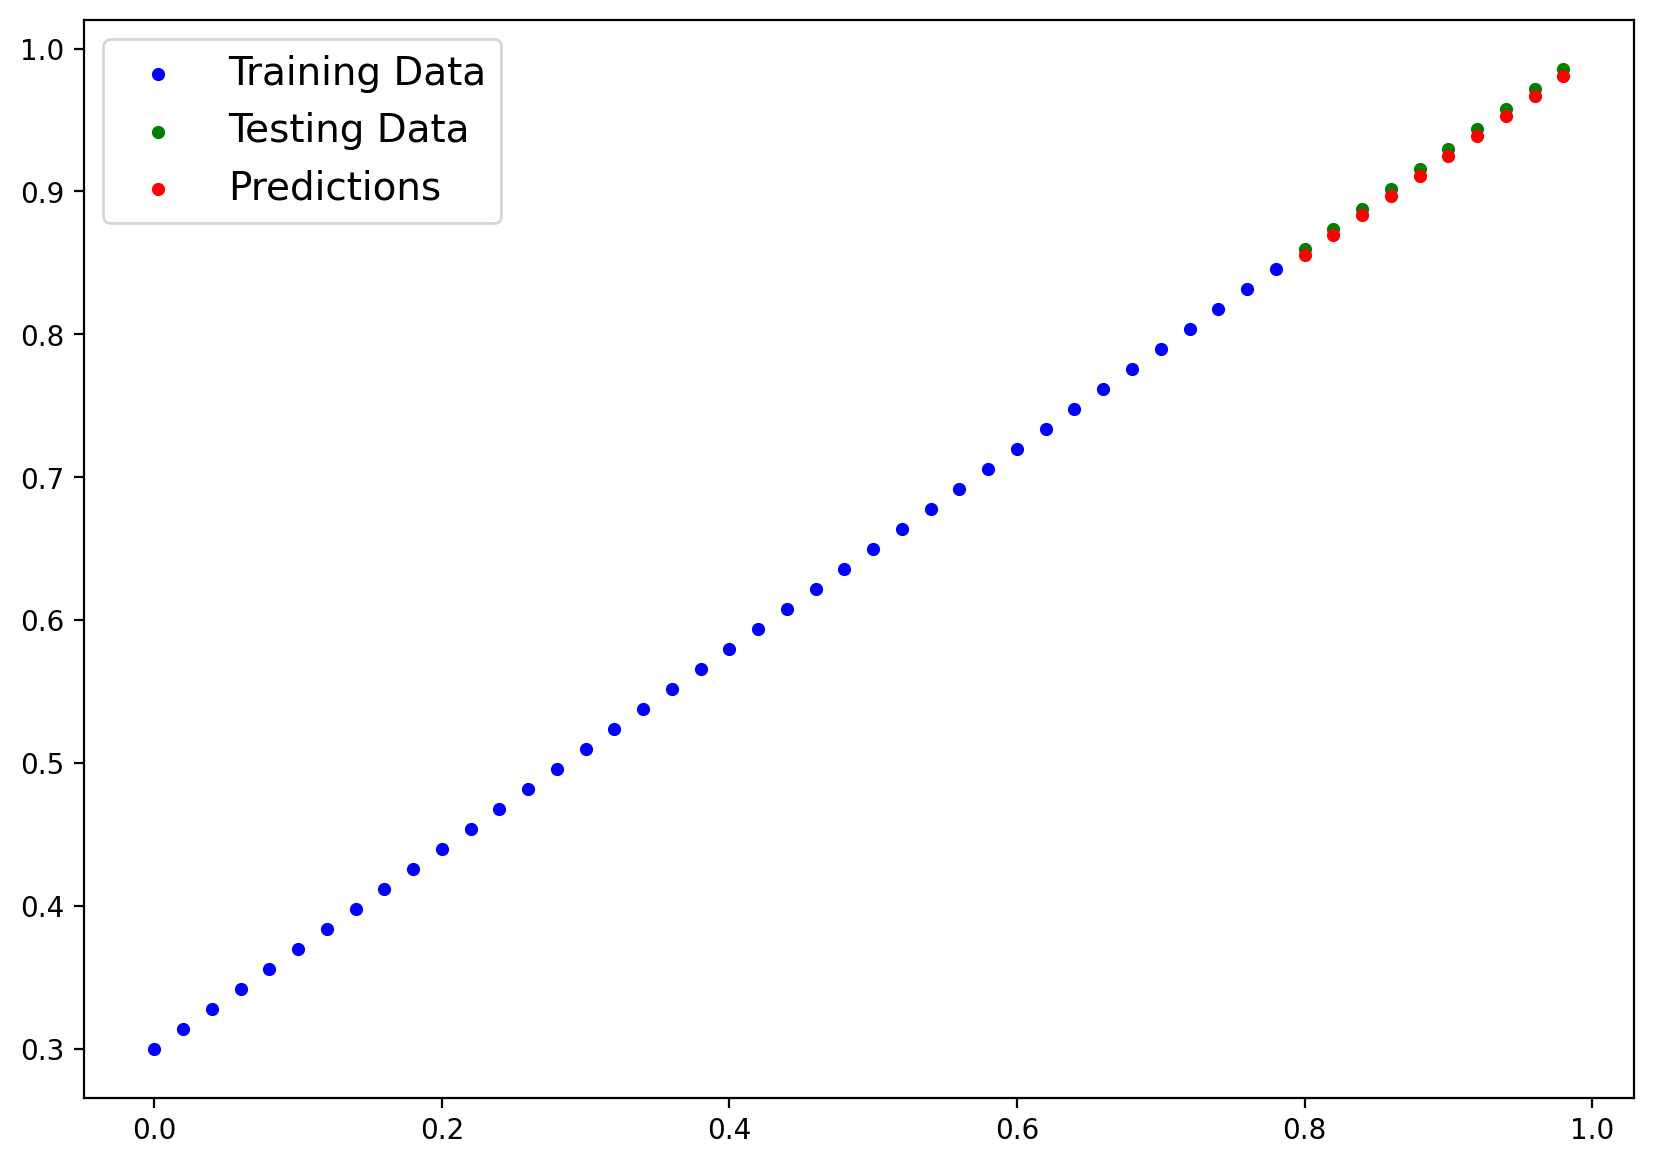

In [26]:
plot_data(predictions=y_preds_new)

## Saving a model in PyTorch
There are three main methods you should know about for saving and loading models in PyTorch.
1. `torch.save()` - allows you to save PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [27]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to: models\01_pytorch_workflow_model_0.pth


## Loading a PyTorch model
Since we saved our model's `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [28]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [29]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegression()

# Load the saved state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [30]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [31]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_preds = loaded_model_0(X_test)

In [32]:
loaded_preds

tensor([[0.8554],
        [0.8693],
        [0.8832],
        [0.8971],
        [0.9110],
        [0.9249],
        [0.9388],
        [0.9527],
        [0.9666],
        [0.9805]])

In [33]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

In [34]:
print(loaded_preds == y_preds)

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])


# Putting it all together

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.__version__

'2.0.1+cu118'

Create device agnostic code

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
device

'cuda'

## 6.1 Data

In [38]:
weight = 0.7
bias = 0.3

start = 0
stop = 1
step = 0.02

X = torch.arange(start, stop, step).unsqueeze(dim=1)

y = weight * X + bias

In [39]:
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

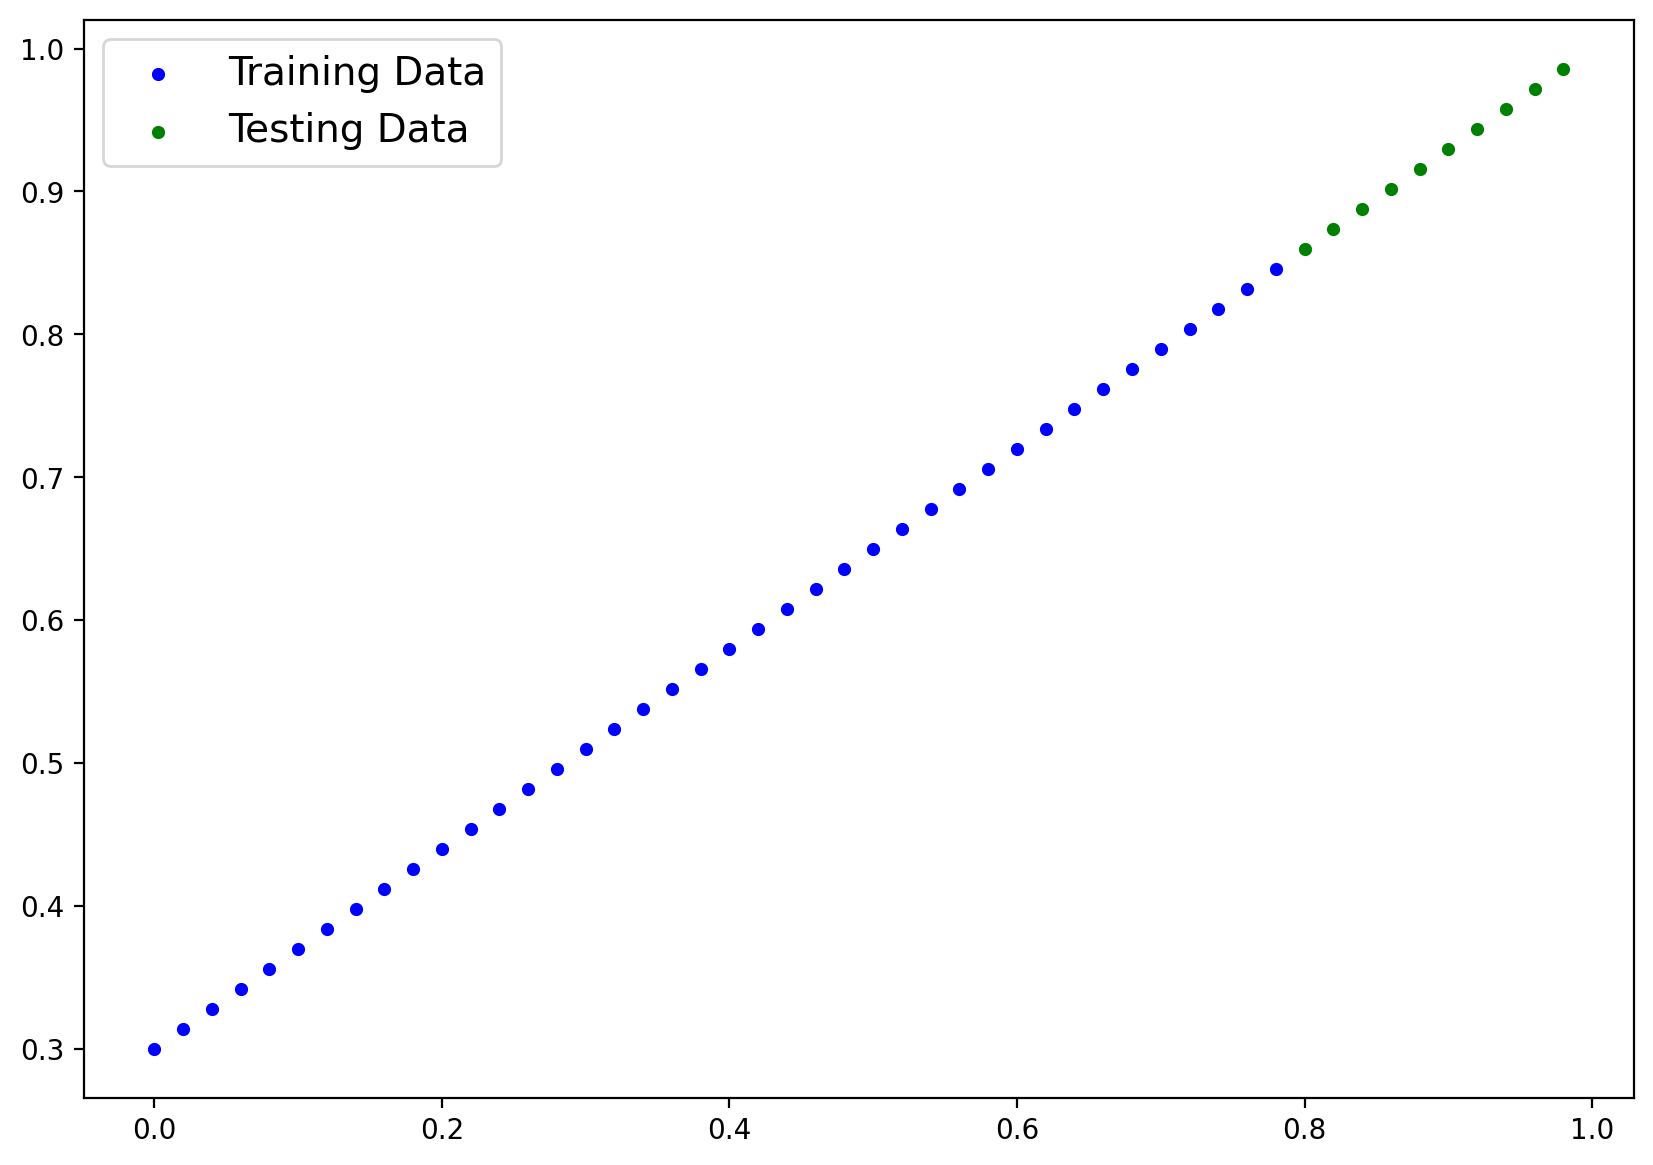

In [40]:
plot_data(X_train, X_test, y_train, y_test)

## 6.2 Building a model

In [41]:
class LinearRegressionV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = torch.nn.Linear(in_features=1,
                                            out_features=1)
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [42]:
torch.manual_seed(42)
model_1 = LinearRegressionV2()
model_1, model_1.state_dict()

(LinearRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [43]:
next(model_1.parameters()).device

device(type='cpu')

In [44]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## 6.3 Training the model

In [45]:
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [46]:
torch.manual_seed(42)
epochs = 200

# Moving our data to GPU
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epoch_count = []
train_loss_values = []
test_loss_values = []
for epoch in range(epochs+1):
    model_1.train()
    y_preds = model_1(X_train)
    train_loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_preds = model_1(X_test)
        test_loss = loss_fn(test_preds, y_test)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train_loss: {train_loss}| Test_loss: {test_loss}")
    epoch_count.append(epoch)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)


Epoch: 0 | Train_loss: 0.5551779270172119| Test_loss: 0.5739762187004089
Epoch: 10 | Train_loss: 0.439968079328537| Test_loss: 0.4392664134502411
Epoch: 20 | Train_loss: 0.3247582018375397| Test_loss: 0.30455657839775085
Epoch: 30 | Train_loss: 0.20954833924770355| Test_loss: 0.16984669864177704
Epoch: 40 | Train_loss: 0.09433845430612564| Test_loss: 0.03513690456748009
Epoch: 50 | Train_loss: 0.023886388167738914| Test_loss: 0.04784907028079033
Epoch: 60 | Train_loss: 0.0199567973613739| Test_loss: 0.045803118497133255
Epoch: 70 | Train_loss: 0.016517987474799156| Test_loss: 0.037530567497015
Epoch: 80 | Train_loss: 0.01308917161077261| Test_loss: 0.02994490973651409
Epoch: 90 | Train_loss: 0.009653178043663502| Test_loss: 0.02167237363755703
Epoch: 100 | Train_loss: 0.0062156799249351025| Test_loss: 0.014086711220443249
Epoch: 110 | Train_loss: 0.002787243574857712| Test_loss: 0.005814164876937866
Epoch: 120 | Train_loss: 0.0012645035749301314| Test_loss: 0.013801801018416882
Epoch: 

In [47]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [48]:
weight, bias

(0.7, 0.3)

## 6.4 Making evaluations

In [49]:
model_1.eval()
with torch.inference_mode():
    model_1_y_preds = model_1(X_test)

In [50]:
model_1_y_preds

tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]], device='cuda:0')

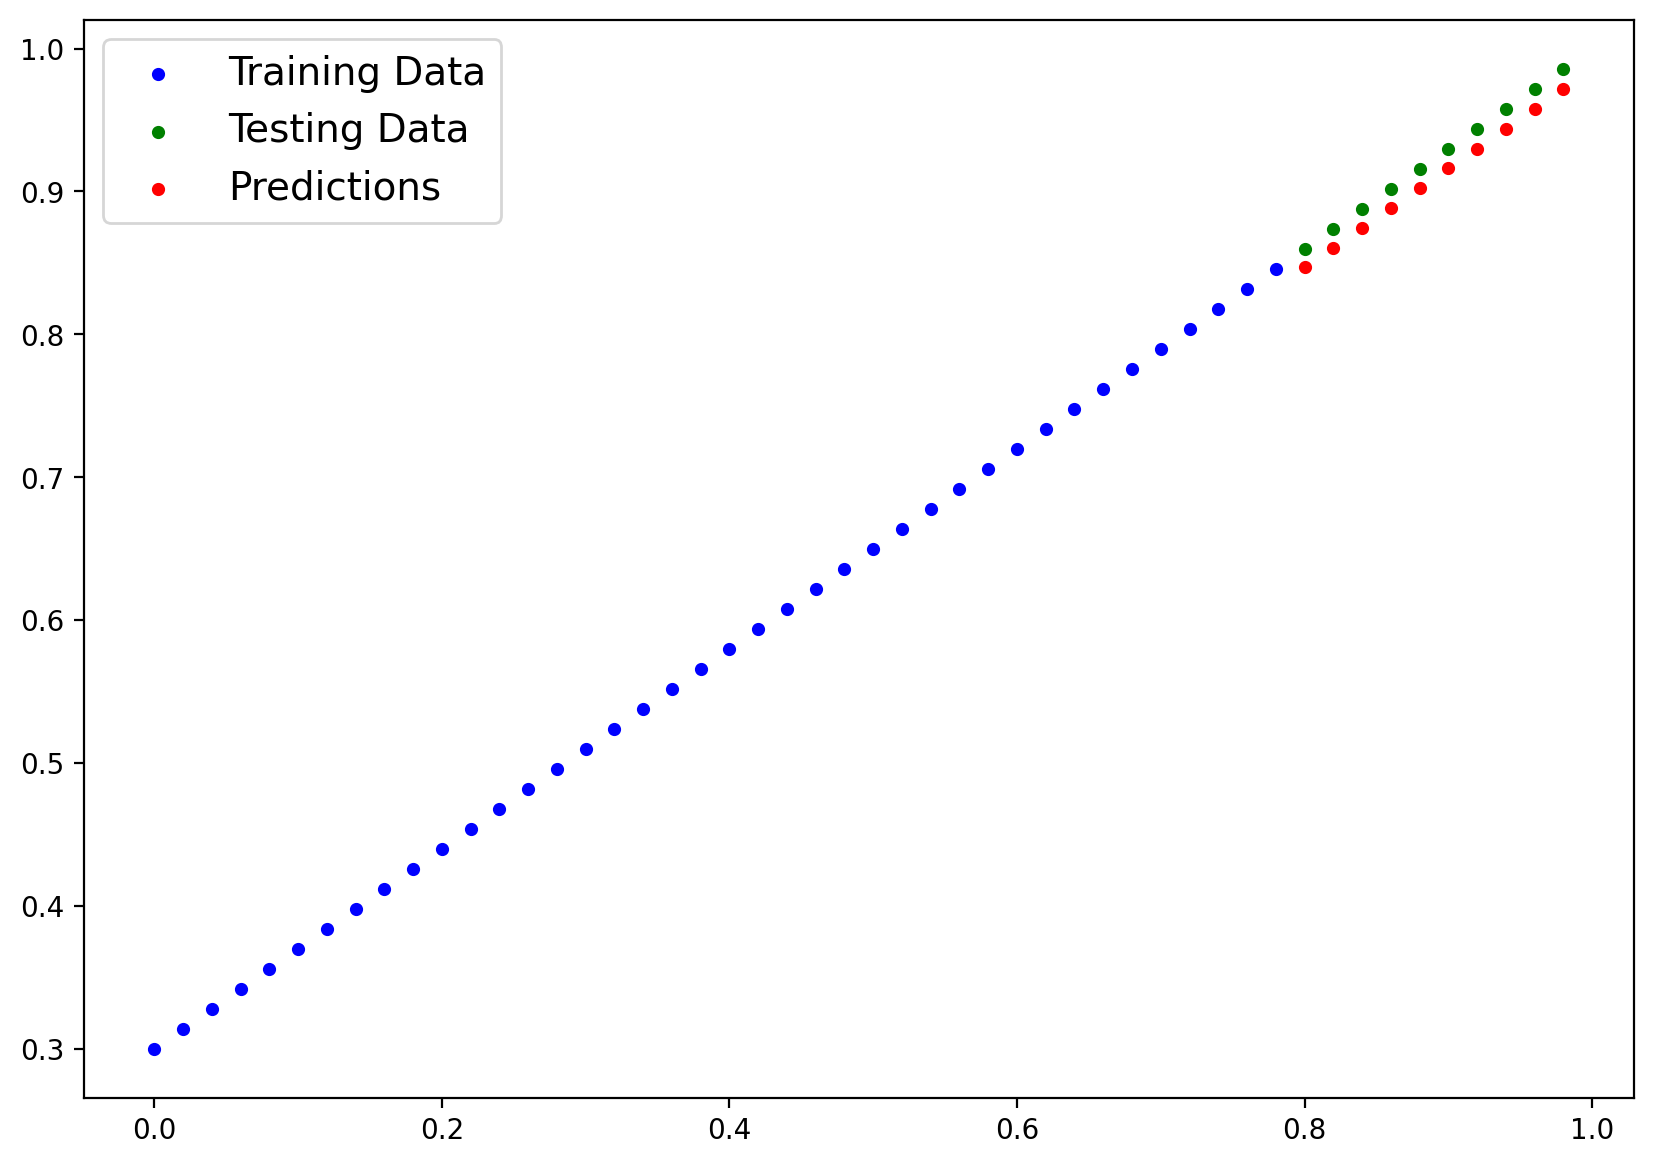

In [52]:
plot_data(predictions=model_1_y_preds.cpu())

## 6.5 Saving and loading models

In [56]:
from pathlib import Path
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_SAVE_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_DIR / MODEL_SAVE_NAME

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [58]:
loaded_model_1 = LinearRegressionV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [59]:
loaded_model_1.to(device)

LinearRegressionV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [60]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds == model_1_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')